In [ ]:
#!pip install mxnet-cu112 #需要安装对应的GPU版本
#!pip install d2l
#!pip install matplotlib-inline
#!pip install matplotlib==3.0.0

In [ ]:
#!pip install tensorflow-gpu==2.9.2

In [ ]:
from tensorflow import keras

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd

#data_file=('/content/gdrive/MyDrive/mydata/IPC2_peptide_100.csv')
#data = pd.read_csv(data_file)
#print(data[0:11])

In [ ]:
#amino_acid_set = { "A": 1, "C": 2, "E": 3, "D": 4, "G": 5, "F": 6, "I": 7, "H": 8, "K": 9, "M": 10, "L": 11, 
#				"N": 12, "Q": 13, "P": 14, "S": 15, "R": 16, "T": 17, "W": 18, "V": 19, "Y": 20, "X": 21 }

#amino_acid_num = 21
#residue_list = list(amino_acid_set.keys())  #定义一个将氨基酸转换为数值的词典

In [ ]:
#def label_sequence(line, pad_prot_len, res_ind):
#  X = np.zeros(pad_prot_len)
#  for i, res in enumerate(line[:pad_prot_len]):
#    X[i] = res_ind[res] #这时候res应该是一个氨基酸，为什么这里是一段序列
#  return X

#feature = label_sequence(pep_seq[1], 50, amino_acid_set) #50是我想去创建图像的一个长度，少于50就填充，多于50就截取，对于肽来说这个长度应该是合适的

我最初想用的是自然语言处理的方式来做这个，把肽序列词元话，然后构建词表。但我又不是想要预测下一个氨基酸是什么。
用CNN做的话就是one_hot化然后做学习什么的

In [ ]:
import numpy as np
from numpy import mat
import pickle

#from mxnet import np, npx
#npx.set_np()

#data_file=('/content/gdrive/MyDrive/mydata/IPC2_peptide_100.csv')

#pep_seq, label_list, feature_list= [], [],[]

#with open(data_file) as f:
#  for line in f.readlines()[1:]:
#    label,seq = line.strip().split(',')
#    pep_seq.append(seq)
#    label_list.append(label)
#    feature = label_sequence(seq, 50, amino_acid_set) #我说为什么一直在输出，定义的label_sequence功能里面有一个print
#    feature = np.array(feature)
#    feature = npx.one_hot(feature,50) #加了一句onehot化，但为什么变这么慢
#    feature_list.append(feature)


In [ ]:
#print(pep_seq[:2],label_list[:2],feature_list[:2],
#    len(pep_seq),len(label_list),len(feature_list))  #我没想到feature_list会这么大，是因为肽数量太多了吗？

In [ ]:
#with open('/content/gdrive/MyDrive/mydata/pep_seq','wb') as f: 
#    pickle.dump(pep_seq,f)
#with open('/content/gdrive/MyDrive/mydata/label_list','wb') as f:
#    pickle.dump(label_list,f)
#with open('/content/gdrive/MyDrive/mydata/feature_list','wb') as f:
#    pickle.dump(feature_list,f)  #计算了还挺久的，赶紧保存了

然后离去训练其实还差挺远的，一是网络需要构建，因为我的label是连续型的数值做回归的任务，所以会和分类型的任务不一样。然后就是需要设置batch_size什么的，暂时也没想要要怎么做

In [ ]:
#with open ('/content/gdrive/MyDrive/mydata/pep_seq', 'rb') as f:
#  pep_seq = pickle.load(f)
#with open ('/content/gdrive/MyDrive/mydata/label_list', 'rb') as f:
#  label_list = pickle.load(f)
#with open ('/content/gdrive/MyDrive/mydata/feature_list', 'rb') as f:
#  feature_list = pickle.load(f)

想了想我都onehot应该是没问题的，但一时半会没想明白为什么是50X50，有好多好多疑惑一时半会想不明白

# keras

In [ ]:
X_label = np.array(label_list[:2000])
X_label = tf.strings.to_number(X_label, out_type=tf.float32)
X_feature = np.array(feature_list[:2000])
X_feature = np.reshape(X_feature, (-1,3,50,50))

In [ ]:
from keras.layers import *
from keras.models import *
from tensorflow.keras import optimizers
import tensorflow as tf


from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_feature, X_label, test_size = 0.75, random_state = 0) #分割训练集和测试集

In [ ]:
!pip install tensorflow-gpu==2.9.2

Python 3.7.15


In [ ]:
model = Sequential()
model.add(Input(shape=(3,50,50)))
model.add(Conv1D(256, 3,activation='relu')) 
model.add(MaxPool1D(45, 3))           
model.add(Conv1D(32, 3, padding='same',activation='relu')) 
model.add(Flatten())                                                               
model.add(Dense(50, activation='relu')) 
model.add(Dropout(0.2))  
model.add(Dense(25, activation='relu'))                                               
model.add(Dense(1, activation='softmax'))              

model.summary()
model.compile(optimizer = 'sgd',                    
        loss = 'mean_squared_error',    
        metrics=['mae'])

#from tensorflow.keras.utils import to_categorical  #这步是onehot操作，但是之前已经做过了
#x_train = to_categorical(x_train,22)

history = model.fit(x_train, y_train, batch_size=125, 
                    epochs=30, validation_split=0.2)

基本没有什么效力，我想试一下啊用更复杂的方法来做，像是残差网络什么的

In [ ]:
print(input_shape)

(3, 50, 50)


# mxnet

有点难以理解mxnet的使用逻辑，对于我来说keras可能是一个好的选择

In [ ]:
from mxnet import np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

class Residual(nn.Block): 
  def __init__(self, num_channels, use_1x1conv=False, strides=1, **kwargs):
    super().__init__(**kwargs)
    self.conv1 = nn.Conv2D(num_channels, kernel_size=3, padding=1,
                strides=strides)
    self.conv2 = nn.Conv2D(num_channels, kernel_size=3, padding=1)
    if use_1x1conv:
      self.conv3 = nn.Conv2D(num_channels, kernel_size=1,
                    strides=strides)
    else:
      self.conv3 = None
    self.bn1 = nn.BatchNorm()
    self.bn2 = nn.BatchNorm()

  def forward(self, X):
    Y = npx.relu(self.bn1(self.conv1(X)))
    Y = self.bn2(self.conv2(Y))
    if self.conv3:
      X = self.conv3(X)
    return npx.relu(Y + X)

In [ ]:
net = nn.Sequential()
net.add(nn.Conv2D(64, kernel_size=7, strides=2, padding=3),
    nn.BatchNorm(), nn.Activation('relu'),
    nn.MaxPool2D(pool_size=3, strides=2, padding=1))

In [ ]:
def resnet_block(num_channels, num_residuals, first_block=False):
  blk = nn.Sequential()
  for i in range(num_residuals):
    if i == 0 and not first_block:
      blk.add(Residual(num_channels, use_1x1conv=True, strides=2))
    else:
      blk.add(Residual(num_channels))
  return blk

In [ ]:
net.add(resnet_block(64, 2, first_block=True),
    resnet_block(128, 2),
    resnet_block(256, 2),
    resnet_block(512, 2))

In [ ]:
net.add(nn.GlobalAvgPool2D(), nn.Dense(10))

In [ ]:
X = np.random.uniform(size=(1, 1, 224, 224))

In [ ]:
net.initialize()
for layer in net:
  X = layer(X)
  print(layer.name, 'output shape:\t', X.shape)

In [ ]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

# 氨基酸序列信息

In [ ]:
!pip install biopython

In [ ]:
import pandas as pd
import numpy as np
from numpy import mat
import pickle
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import math
from tensorflow.keras.utils import to_categorical

In [ ]:
from keras.layers import *
from keras.models import *
from tensorflow.keras import optimizers
import tensorflow as tf

from sklearn.model_selection import train_test_split

In [ ]:
encoder = {'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13,
           'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20, 'X': 0}
frequency = {'A': 0, 'C': 0, 'D': 0, 'E': 0, 'F': 0, 'G': 0, 'H': 0, 'I': 0, 'K': 0, 'L': 0, 'M': 0, 'N': 0, 'P': 0,
             'Q': 0, 'R': 0, 'S': 0, 'T': 0, 'V': 0, 'W': 0, 'Y': 0, 'X': 0}
hydropathy = {'A': 1.8, 'C': 2.5, 'D': -3.5, 'E': -3.5, 'F': 2.8, 'G': -0.4, 'H': -3.2, 'I': 4.5, 'K': -3.9, 'L': 3.8,
              'M': 1.9, 'N': -3.5, 'P': -1.6, 'Q': -3.5, 'R': -4.5, 'S': -0.8, 'T': -0.7, 'V': 4.2, 'W': -0.9,
              'Y': -1.3, 'X': 0.0}
volume = {'A': 91.5, 'C': 118.0, 'D': 124.5, 'E': 155.1, 'F': 203.4, 'G': 66.4, 'H': 167.3, 'I': 168.8, 'K': 171.3,
          'L': 167.9, 'M': 170.8, 'N': 135.2, 'P': 129.3, 'Q': 161.1, 'R': 202.0, 'S': 99.1, 'T': 122.1, 'V': 141.7,
          'W': 237.6, 'Y': 203.6, 'X': 0.0}
polarity = {'A': 0.0, 'C': 1.48, 'D': 40.7, 'E': 49.91, 'F': 0.35, 'G': 0.0, 'H': 51.6, 'I': 0.15, 'K': 49.5, 'L': 0.45,
            'M': 1.43, 'N': 3.38, 'P': 1.58, 'Q': 3.53, 'R': 52.0, 'S': 1.67, 'T': 1.66, 'V': 0.13, 'W': 2.1, 'Y': 1.61,
            'X': 0.0}
pK_side_chain = {'A': 0.0, 'C': 8.18, 'D': 3.65, 'E': 4.25, 'F': 0.0, 'G': 0.0, 'H': 6.0, 'I': 0.0, 'K': 10.53,
                 'L': 0.0, 'M': 0.0, 'N': 0.0, 'P': 0.0, 'Q': 0.0, 'R': 12.48, 'S': 0.0, 'T': 0.0, 'V': 0.0, 'W': 0.0,
                 'Y': 10.7, 'X': 0.0}
prct_exposed_residues = {'A': 15.0, 'C': 5.0, 'D': 50.0, 'E': 55.0, 'F': 10.0, 'G': 10.0, 'H': 34.0, 'I': 13.0,
                         'K': 85.0, 'L': 16.0, 'M': 20.0, 'N': 49.0, 'P': 45.0, 'Q': 56.0, 'R': 67.0, 'S': 32.0,
                         'T': 32.0, 'V': 14.0, 'W': 17.0, 'Y': 41.0, 'X': 0.0}
hydrophilicity = {'A': -0.5, 'C': -1.0, 'D': 3.0, 'E': 3.0, 'F': -2.5, 'G': 0.0, 'H': -0.5, 'I': -1.8, 'K': 3.0,
                  'L': -1.8, 'M': -1.3, 'N': 0.2, 'P': 0.0, 'Q': 0.2, 'R': 3.0, 'S': 0.3, 'T': -0.4, 'V': -1.5,
                  'W': -3.4, 'Y': -2.3, 'X': 0.0}
accessible_surface_area = {'A': 27.8, 'C': 15.5, 'D': 60.6, 'E': 68.2, 'F': 25.5, 'G': 24.5, 'H': 50.7, 'I': 22.8,
                           'K': 103.0, 'L': 27.6, 'M': 33.5, 'N': 60.1, 'P': 51.5, 'Q': 68.7, 'R': 94.7, 'S': 42.0,
                           'T': 45.0, 'V': 23.7, 'W': 34.7, 'Y': 55.2, 'X': 0.0}
refractivity = {'A': 4.34, 'C': 35.77, 'D': 12.0, 'E': 17.26, 'F': 29.4, 'G': 0.0, 'H': 21.81, 'I': 19.06, 'K': 21.29,
                'L': 18.78, 'M': 21.64, 'N': 13.28, 'P': 10.93, 'Q': 17.56, 'R': 26.66, 'S': 6.35, 'T': 11.01,
                'V': 13.92, 'W': 42.53, 'Y': 31.53, 'X': 0.0}
local_flexibility = {'A': 705.42, 'C': 2412.5601, 'D': 34.96, 'E': 1158.66, 'F': 5203.8599, 'G': 33.18, 'H': 1637.13,
                     'I': 5979.3701, 'K': 699.69, 'L': 4985.73, 'M': 4491.6602, 'N': 513.4601, 'P': 431.96,
                     'Q': 1087.83, 'R': 1484.28, 'S': 174.76, 'T': 601.88, 'V': 4474.4199, 'W': 6374.0698,
                     'Y': 4291.1001, 'X': 0.0}
accessible_surface_area_folded = {'A': 31.5, 'C': 13.9, 'D': 60.9, 'E': 72.3, 'F': 28.7, 'G': 25.2, 'H': 46.7,
                                  'I': 23.0, 'K': 110.3, 'L': 29.0, 'M': 30.5, 'N': 62.2, 'P': 53.7, 'Q': 74.0,
                                  'R': 93.8, 'S': 44.2, 'T': 46.0, 'V': 23.5, 'W': 41.7, 'Y': 59.1, 'X': 0.0}
mass = {'A': 70.079, 'C': 103.144, 'D': 115.089, 'E': 129.116, 'F': 147.177, 'G': 57.052, 'H': 137.142, 'I': 113.16,
        'K': 128.174, 'L': 113.16, 'M': 131.198, 'N': 114.104, 'P': 97.177, 'Q': 128.131, 'R': 156.188, 'S': 87.078,
        'T': 101.105, 'V': 99.133, 'W': 186.213, 'Y': 163.17, 'X': 0.0}
solvent_exposed_area = {'A': 0.48, 'C': 0.32, 'D': 0.81, 'E': 0.93, 'F': 0.42, 'G': 0.51, 'H': 0.66, 'I': 0.39,
                        'K': 0.93, 'L': 0.41, 'M': 0.44, 'N': 0.82, 'P': 0.78, 'Q': 0.81, 'R': 0.84, 'S': 0.7,
                        'T': 0.71, 'V': 0.4, 'W': 0.49, 'Y': 0.67, 'X': 0.0}


def seqToMat(seq):
    n = dim
    seq_Mat = [0 for x in range(n)]
    hydropathy_Mat = [0 for x in range(n)]
    volume_Mat = [0 for x in range(n)]
    polarity_Mat = [0 for x in range(n)]
    pK_side_chain_Mat = [0 for x in range(n)] 
    prct_exposed_residues_Mat = [0 for x in range(n)]
    hydrophilicity_Mat = [0 for x in range(n)]
    accessible_surface_area_Mat = [0 for x in range(n)]
    refractivity_Mat = [0 for x in range(n)]
    local_flexibility_Mat = [0 for x in range(n)]
    accessible_surface_area_folded_Mat = [0 for x in range(n)]
    mass_Mat = [0 for x in range(n)]
    solvent_exposed_area_Mat = [0 for x in range(n)]

    seqiter = 0
    for i in range(n):
          if seqiter < len:
              try:
                  seq_Mat_v = encoder[seq[seqiter]]
                  hydropathy_Mat_v = hydropathy[seq[seqiter]]
                  volume_Mat_v = volume[seq[seqiter]]
                  polarity_Mat_v = polarity[seq[seqiter]]
                  pK_side_chain_Mat_v = pK_side_chain[seq[seqiter]]
                  prct_exposed_residues_Mat_v = prct_exposed_residues[seq[seqiter]]
                  hydrophilicity_Mat_v = hydrophilicity[seq[seqiter]]
                  accessible_surface_area_Mat_v = accessible_surface_area[seq[seqiter]]
                  refractivity_Mat_v = refractivity[seq[seqiter]]
                  local_flexibility_Mat_v = local_flexibility[seq[seqiter]]
                  accessible_surface_area_folded_Mat_v = accessible_surface_area_folded[seq[seqiter]]
                  mass_Mat_v = mass[seq[seqiter]]
                  solvent_exposed_area_Mat_v = solvent_exposed_area[seq[seqiter]]
              except ValueError:
                  exit(0)
              else:
                  seq_Mat[i] = seq_Mat_v
                  hydropathy_Mat[i] = hydropathy_Mat_v
                  volume_Mat[i] = volume_Mat_v
                  polarity_Mat[i] = polarity_Mat_v
                  pK_side_chain_Mat[i] = pK_side_chain_Mat_v
                  prct_exposed_residues_Mat[i] = prct_exposed_residues_Mat_v
                  hydrophilicity_Mat[i]= hydrophilicity_Mat_v
                  accessible_surface_area_Mat[i] = accessible_surface_area_Mat_v
                  refractivity_Mat[i] = refractivity_Mat_v
                  local_flexibility_Mat[i] = local_flexibility_Mat_v
                  accessible_surface_area_folded_Mat[i] = accessible_surface_area_folded_Mat_v
                  mass_Mat[i] = mass_Mat_v
                  solvent_exposed_area_Mat[i] = solvent_exposed_area_Mat_v
              seqiter += 1
    #print(seq_Mat)
    array1,array2 = np.asarray(np.array(to_categorical(seq_Mat))), np.asarray(np.concatenate([
        hydropathy_Mat , volume_Mat , polarity_Mat , pK_side_chain_Mat , \
        prct_exposed_residues_Mat , hydrophilicity_Mat , accessible_surface_area_Mat , \
        refractivity_Mat , local_flexibility_Mat , accessible_surface_area_folded_Mat , \
        mass_Mat , solvent_exposed_area_Mat], axis=0).reshape(-1,n))
    array1 = np.delete(array1, 1, axis=1)
    array1 = np.transpose(array1)
    array1 = np.pad(array1,((0,50-array1.shape[0]),(0,50-array1.shape[1])),'constant',constant_values = (0,0))
    array2 = np.pad(array2,((0,50-array2.shape[0]),(0,50-array2.shape[1])),'constant',constant_values = (0,0))
    return array1, array2


def freqMat(seq):
    n = dim
    freq_Mat = [0 for x in range(n)]
    X = ProteinAnalysis(str(seq))
    frequency['A'] = X.count_amino_acids()['A']
    frequency['C'] = X.count_amino_acids()['C']
    frequency['D'] = X.count_amino_acids()['D']
    frequency['E'] = X.count_amino_acids()['E']
    frequency['F'] = X.count_amino_acids()['F']
    frequency['G'] = X.count_amino_acids()['G']
    frequency['H'] = X.count_amino_acids()['H']
    frequency['I'] = X.count_amino_acids()['I']
    frequency['K'] = X.count_amino_acids()['K']
    frequency['L'] = X.count_amino_acids()['L']
    frequency['M'] = X.count_amino_acids()['M']
    frequency['N'] = X.count_amino_acids()['N']
    frequency['P'] = X.count_amino_acids()['P']
    frequency['Q'] = X.count_amino_acids()['Q']
    frequency['R'] = X.count_amino_acids()['R']
    frequency['S'] = X.count_amino_acids()['S']
    frequency['T'] = X.count_amino_acids()['T']
    frequency['V'] = X.count_amino_acids()['V']
    frequency['W'] = X.count_amino_acids()['W']
    frequency['Y'] = X.count_amino_acids()['Y']

    seqiter = 0
    for i in range(n):
          if seqiter < len:
              try:
                  freq_Mat_v = frequency[seq[seqiter]]
              except ValueError:
                  exit(0)
              else:
                  freq_Mat[i]= freq_Mat_v
              seqiter += 1
    array3=np.expand_dims(freq_Mat,0).repeat(21,axis=0)
    array3 = np.pad(array3,((0,50-array3.shape[0]),(0,50-array3.shape[1])),'constant',constant_values = (0,0))
    return np.asarray(array3)

In [ ]:
len=8
dim=len

array1,array2=seqToMat('GISETHDE')
array3=freqMat('GISETHDE')

ch3 = np.dstack([array1,array2,array3])

In [ ]:
import re
test = "GISETHDE"
test = re.findall('[a-zA-Z]',test)
len=np.array(test).shape[0]
dim = len

OK特征的提取已经完全准备好了，然后重新读一遍数据

In [ ]:
#!shuf -n40000 /content/gdrive/MyDrive/mydata/IPC2_peptide_100.csv > /content/gdrive/MyDrive/mydata/IPC2_peptide_40000.csv #在python里实在不好做这个操作在linux里解决了

In [ ]:
data_file=('/content/gdrive/MyDrive/mydata/IPC2_peptide_40000.csv')

pep_seq, label_list, feature_list= [], [],[]

with open(data_file) as f:
  for line in f.readlines()[1:]:
    label,seq = line.strip().split(',')

    test = re.findall('[a-zA-Z]',seq)
    len = np.array(test).shape[0]
    dim = len

    if len>50:
      pass 
    else: 
      array1,array2=seqToMat(seq) #这里会有报错，我猜是遇到长度大于50的肽了
      array3=freqMat(seq)

      ch3 = np.dstack([array1,array2,array3]) #这里ipc2的代码就是dstack呀
      pep_seq.append(seq)
      label_list.append(label)
      feature_list.append(ch3)  #比之前写的那段循环要快

In [ ]:
print(feature_list[1])

In [ ]:
label_list = np.array(label_list)
feature_list = np.array(feature_list) #feature_list这个变量实在是太大了，以至于对计算产生了较大影响
#feature_list = np.reshape(feature_list, (-1,3,50,50)) 

In [ ]:
with open('/content/gdrive/MyDrive/mydata/pep_seq','wb') as f: 
    pickle.dump(pep_seq[:100],f)
with open('/content/gdrive/MyDrive/mydata/label_list','wb') as f:
    pickle.dump(label_list[:100],f)
with open('/content/gdrive/MyDrive/mydata/feature_list','wb') as f:
    pickle.dump(feature_list[:100],f)

In [ ]:
np.array(label_list).shape[0]

39996

In [ ]:
#import random

#sample_num = int(0.1 * np.array(label_list).shape[0]) 
#sample_list = [i for i in range(np.array(label_list).shape[0])]
#sample_list = random.sample(sample_list, sample_num)

#X_label = np.array(label_list)[sample_list]
#X_feature = np.array(feature_list)[sample_list] #想随机抽一些样看训练会不会好一些，主要内存老崩，做什么操作都很麻烦
#X_feature = np.reshape(X_feature, (-1,3,50,50)) 

In [ ]:
#np.array(label_list).shape

(119080,)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(feature_list, label_list, test_size = 0.25, random_state = 0) #分割训练集和测试集

In [ ]:
x_train = np.array(x_train,dtype='uint8')
y_train = np.array(y_train)
y_train = y_train.astype(float)  #似乎默认给我弄成字符型了，需要改成数值型才能够做回归的建模
x_test = np.array(x_test,dtype='uint8')
y_test = np.array(y_test)
y_test = y_test.astype(float)
print(type(y_train),y_train[:5])

<class 'numpy.ndarray'> [6.355 4.393 4.494 7.879 6.05 ]


In [ ]:
model = Sequential()
model.add(SeparableConv2D(50, (22, 5), padding='same', input_shape=[50,50,3], activation='selu')) #这里的步幅指明卷积沿高度和宽度方向的步长，所以在做数组时我们不应该往高度上叠而是往长度（第三轴）上面叠？
model.add(AveragePooling2D(pool_size=(2, 4)))
model.add(SeparableConv2D(400, (3, 3), padding='same', activation='selu'))
model.add(AveragePooling2D(pool_size=(1, 3))) 
model.add(Flatten())
model.add(Dense(units = 60, activation = 'selu'))
model.add(Dense(units = 60, activation = 'selu'))
#model.add(Dropout(0.2))
model.add(Dense(units = 60, activation = 'selu'))        
model.add(Dense(units = 1, kernel_initializer='normal', activation="linear"))

In [ ]:
model.summary()

In [ ]:
print(pep_seq[1],y_train[1])

VAPEEVSEVIFGHVLTAGCGQNPTR 4.393


In [ ]:
model.compile(optimizer = 'adam',loss = 'mean_absolute_percentage_error')

history = model.fit(x_train, y_train, batch_size=125, epochs=20, validation_data=(x_test, y_test),) #至少有正常在跑了，感动，就是这个性能.....
                                                      #今天GPU运行时用完了，CPU小跑一下

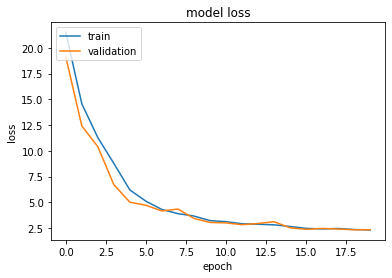

In [ ]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()  #更大的样本量显著的增强了表现
       #感觉加大数据量之后，测试集好像没有表现更好，反而提早过拟合了？
       #之前居然一直在用0.25的训练集在跑，怪不得表现一直不好。感觉把数据集再加大还能降低loss
       #这个三维数据的维度我是完全理解错了，有点难以转的过来，改过之后损失表现好得离谱

In [ ]:
print(pep_seq[158], y_train[158])

VISVSTSER 6.15


In [ ]:
#随手做个测试
test = "AAAAASAAGPGGLVAGKEEK"
test = re.findall('[a-zA-Z]',test)
len=np.array(test).shape[0]
print(len)

test1,test2 = seqToMat('AAAAASAAGPGGLVAGKEEK') 
test3 = freqMat('AAAAASAAGPGGLVAGKEEK')
test = np.dstack([test1,test2,test3])

test2 = []
test2.append(test)
test2 = np.array(test2,dtype='uint8')
test2.shape   #之前的维度确实做的有问题

20


(1, 50, 50, 3)

In [ ]:
predictions = model.predict(test2) #但，就一些是准的，另外一些就差得比较远，不知道迭代更多次会不会好，现在每次迭代还挺慢的
print(predictions) 

1/1 [==============================] - 0s 18ms/step
[[6.772411]]


# 残差网络

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(feature_list, label_list, test_size = 0.25, random_state = 0) #同样的数据
x_train = np.array(x_train,dtype='uint8')
y_train = np.array(y_train)
y_train = y_train.astype(float)  #似乎默认给我弄成字符型了，需要改成数值型才能够做回归的建模
x_test = np.array(x_test,dtype='uint8')
y_test = np.array(y_test)
y_test = y_test.astype(float)

In [ ]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os

# 训练参数
batch_size = 32  # 原论文按照 batch_size=128 训练所有的网络
epochs = 200
data_augmentation = False
num_classes = 60

n = 6
version = 2 #有一个对照的表格可以看用哪个版本的残差，什么的

# 从提供的模型参数 n 计算的深度
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# 模型名称、深度和版本
model_type = 'ResNet%dv%d' % (depth, version)

# 输入图像维度。
input_shape = x_train.shape[1:]

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)


def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def resnet_layer(inputs,
          num_filters=16,
          kernel_size=3,
          strides=1,
          activation='relu',
          batch_normalization=True,
          conv_first=True):
    conv = Conv2D(num_filters,
            kernel_size=kernel_size,
            strides=strides,
            padding='same',
            kernel_initializer='he_normal',
            kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=10):
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # 开始模型定义
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # 实例化残差单元的堆栈
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # 第一层但不是第一个栈
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                      num_filters=num_filters,
                      strides=strides)
            y = resnet_layer(inputs=y,
                      num_filters=num_filters,
                      activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # 线性投影残差快捷键连接，以匹配更改的 dims
                x = resnet_layer(inputs=x,
                          num_filters=num_filters,
                          kernel_size=1,
                          strides=strides,
                          activation=None,
                          batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # 在顶层加分类器。
    # v1 不在最后一个快捷连接 ReLU 后使用 BN
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
             activation='selu',
             kernel_initializer='he_normal')(y)

    # 实例化模型。
    model = Model(inputs=inputs, outputs=outputs)
    return model


def resnet_v2(input_shape, depth, num_classes=10):
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # 开始模型定义。
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 在将输入分离为两个路径前执行带 BN-ReLU 的 Conv2D 操作。
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # 实例化残差单元的栈
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # 瓶颈残差单元
            y = resnet_layer(inputs=x,
                      num_filters=num_filters_in,
                      kernel_size=1,
                      strides=strides,
                      activation=activation,
                      batch_normalization=batch_normalization,
                      conv_first=False)
            y = resnet_layer(inputs=y,
                      num_filters=num_filters_in,
                      conv_first=False)
            y = resnet_layer(inputs=y,
                      num_filters=num_filters_out,
                      kernel_size=1,
                      conv_first=False)
            if res_block == 0:
                # 线性投影残差快捷键连接，以匹配更改的 dims
                x = resnet_layer(inputs=x,
                          num_filters=num_filters_out,
                          kernel_size=1,
                          strides=strides,
                          activation=None,
                          batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # 在顶层添加分类器
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
             activation='selu',
             kernel_initializer='he_normal')(y)

    # 实例化模型。
    model = Model(inputs=inputs, outputs=outputs)
    return model

x_train shape: (29997, 50, 50, 3)
29997 train samples
9999 test samples
y_train shape: (29997,)


In [ ]:
if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)  #想要构建一个残差的网络怎么就这么麻烦呢
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='mean_absolute_error',
       optimizer='adam')

model.summary()
print(model_type)

In [ ]:
history = model.fit(x_train, y_train, batch_size=125, epochs=20, validation_data=(x_test, y_test),)  

#改了一下后倒是能正常运行了，但是模型几乎没有学习能力，还是考虑是否积卷大小和步幅什么的有问题
#把激活函数改了一下，对于测试集的表现很好，对于评估集怎么差这么多啊，迭代几次后好像好很多了，可能是个例吧
#上面那个简单的CNN20次迭代后评估集的loss能到2.5左右（mape），看看用残差的话能做到多少吧，好像残差很容易过拟合？

In [2]:
import os
os.getcwd()

'/content'

In [ ]:
save_dir = '/content/gdrive/MyDrive/my_ai/'
model_name = 'resnet_model.{epoch:03d}.h5' % model_type

filepath = os.path.join(save_dir, model_name)

# 准备保存模型和学习速率调整的回调。
checkpoint = ModelCheckpoint(filepath=filepath,
                monitor='val_loss',
                verbose=1,
                save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                 cooldown=0,
                 patience=5,
                 min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

#
history = model.fit(x_train, y_train,
           batch_size=125,
           epochs=200,
           validation_data=(x_test, y_test),
           shuffle=True,  #在训练过程中数据是否会混洗,这个默认就是ture
           callbacks=callbacks) #之前都没有设置过回调，在较大的数据集复杂的模型训练时这是非常重要的

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='/content/gdrive/MyDrive/my_ai/model.png')  #对于模型的可视化的代码

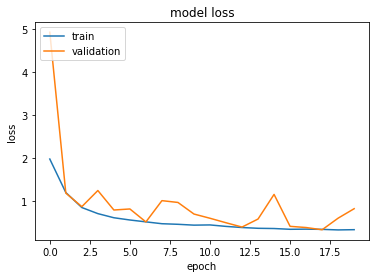

In [ ]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
#随手做个测试
test = "AAAANLCPGDVILAIDGFGTESMTHADAQDR"
test = re.findall('[a-zA-Z]',test)
len=np.array(test).shape[0]
print(len)

test1,test2 = seqToMat('AAAANLCPGDVILAIDGFGTESMTHADAQDR') 
test3 = freqMat('AAAANLCPGDVILAIDGFGTESMTHADAQDR')
test = np.dstack([test1,test2,test3])

test2 = []
test2.append(test)
test2 = np.array(test2,dtype='uint8')

predictions = model.predict(test2) 
print(predictions) #为什么出这么一堆结果，是要我取平均值吗

31
1/1 [==============================] - 1s 889ms/step
[[4.837154  4.8838353 4.8394055 4.8720636 4.83396   4.852988  4.658608
  4.858465  4.9176283 4.76993  ]]


In [ ]:
#还可以，20次迭代的表现不如之前用到的简单CNN，但更多的迭代次数可能会有更好的表现
#然后对于损失函数，我不应该用mape这样会让模型对于低等电点的肽预测准确但是对于高等电点的函数预测不准确
#残差在我的理解中，一直是一个大力出奇迹的方法，这个模型能用就已经让我很开心了